In [65]:
import sys
import os 
import logging
import json
import argparse

# Use absolute imports instead of relative imports (remove the dots)
from opsinth.analysis_genes import run_find_genes
from opsinth.igv_web import create_igv_html, open_igv_viewer
from opsinth.config import DEFAULTS, VARIANTS, VERSION

# Automatically reload modules when they are changed
%load_ext autoreload
%autoreload 2

import logging
from IPython.display import display, HTML

# Configure logging for notebook display
class NotebookHandler(logging.Handler):
    def emit(self, record):
        # Convert log record to HTML with different colors based on level
        level_colors = {
            'DEBUG': 'grey',
            'INFO': 'black',
            'WARNING': 'orange',
            'ERROR': 'red',
            'CRITICAL': 'darkred'
        }
        color = level_colors.get(record.levelname, 'black')
        msg = f'<pre style="margin:0; color:{color};">{self.format(record)}</pre>'
        display(HTML(msg))

# Set up the logger
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)  # Set to DEBUG if you want to see debug messages

# Remove any existing handlers
for handler in logger.handlers[:]:
    logger.removeHandler(handler)

# Add the notebook handler
notebook_handler = NotebookHandler()
formatter = logging.Formatter('%(levelname)s: %(message)s')
notebook_handler.setFormatter(formatter)
logger.addHandler(notebook_handler)

# Now your logging output will appear in the notebook
# Example usage:
logging.info("Starting analysis...")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
out_prefix = "nb_test_output"

bam = "../tests/input/wgs_short.locus.bam"
bed = "../tests/input/opsin_region.bed"
ref = "../data/grch38.chrX.roi.fa.gz"
anchors = "../tests/input/anchors.fasta"
json_file = "../tests/input/wgs_short.paraphase.json"
fasta_seq_file = "../tests/input/opsin_nodes_seq.fa"

/home/caspar/.local/share/virtualenvs/opsinth-t7B0e5fO/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


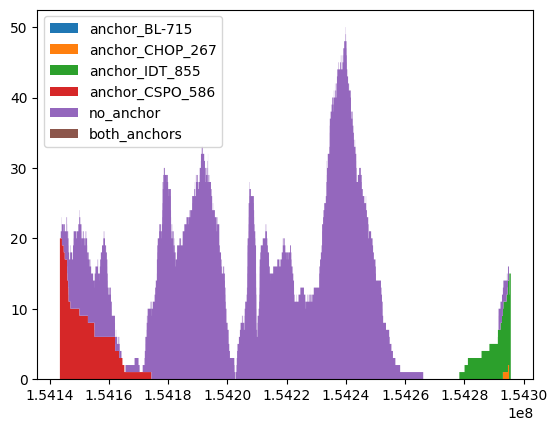

In [8]:
from opsinth.utils import write_bam
from opsinth.plots import plot_coverage, plot_alignment_quality
write_bam(results_ref.get('reads_aligned'), results_ref.get('reads'), results_ref.get('roi'), (out_prefix + ".refbased"), VERSION, bam)
plot_coverage(results_ref, (out_prefix + ".refbased"), create_file = False)


Lots of reads without anchors, lots of gaps

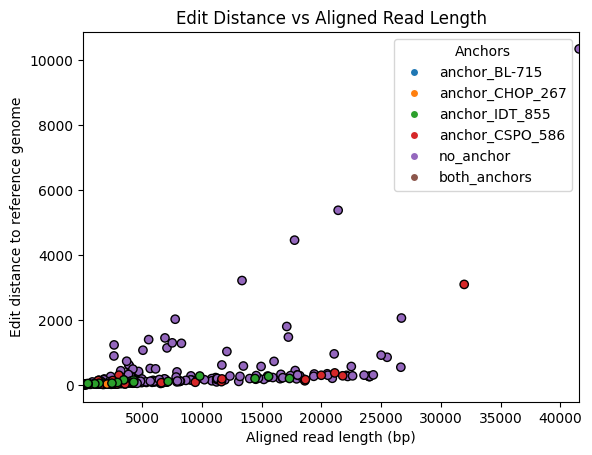

In [9]:
plot_alignment_quality(results_ref, (out_prefix + ".refbased"), create_file = False)

In [10]:
# Create draft ref up to the new code
from opsinth.analysis_sequence import create_draft_from_overlaps, create_draft_from_graph

candidate_reads = {}
double_anchor_reads = results_ref['double_anchor_reads']
reads = results_ref['reads']
anchors_on_reads = results_ref['anchors_on_reads']
seq = ""

# Option 1: There is at least 1 double anchor read
if len(results_ref['double_anchor_reads']) > 0:
    
    for read in double_anchor_reads:

        # Calculate anchor distances
        anchor1 = double_anchor_reads[read][0]
        anchor2 = double_anchor_reads[read][1]
        lower_anchor = anchor1 if anchors_on_reads[read][anchor1]['locations'][0][0] < anchors_on_reads[read][anchor2]['locations'][0][0] else anchor2
        upper_anchor = anchor2 if lower_anchor == anchor1 else anchor1
        pos_lower_anchor = anchors_on_reads[read][lower_anchor]['locations'][0][0]
        pos_upper_anchor = anchors_on_reads[read][upper_anchor]['locations'][0][1]
        
        candidate_reads[read] = {
            'anchor_distance': pos_upper_anchor - pos_lower_anchor,
            'lower_anchor': lower_anchor,
            'upper_anchor': upper_anchor,
            'pos_lower_anchor': pos_lower_anchor,
            'pos_upper_anchor': pos_upper_anchor,
            'edit_distance': anchors_on_reads[read][lower_anchor]['editDistance'] + anchors_on_reads[read][upper_anchor]['editDistance']
        }

    # Select best candidate read by minimum edit distance of both anchors, then by anchor distance
    # Todo: Maybe also consider read quality
    best_read = min(candidate_reads, key=lambda r: (candidate_reads[r]['edit_distance'], candidate_reads[r]['anchor_distance']))

    logging.info("Create draft ref from double anchor read")
    logging.info("Best read: %s, edit distance: %d, anchor distance: %d", best_read, candidate_reads[best_read]['edit_distance'], candidate_reads[best_read]['anchor_distance'])

    seq = reads[best_read]['seq_query'][candidate_reads[best_read]['pos_lower_anchor']:candidate_reads[best_read]['pos_upper_anchor']]
# Option 2: There is no double anchor read, try to find alignment of overlapping reads
else:
    #try:
    #    seq = create_draft_from_overlaps(results_ref['reads'], results_ref['unique_anchor_reads'], results_ref['anchors_on_ref'], results_ref['anchors_on_reads'])
    #except:
    logging.error("Could not create draft ref from overlapping reads")
    seq = create_draft_from_graph(results_ref)

seq

In [74]:
from opsinth.sequence_graph import *

paraphase_nodes = parse_paraphase_nodes(json_file)
logging.info("Paraphase nodes: %s", paraphase_nodes)


AttributeError: 'str' object has no attribute 'items'

In [72]:
logging.basicConfig(level=logging.DEBUG)
from opsinth.sequence_graph import *
# Initialize sequence manager and load sequences
seq_manager = SequenceManager()
seq_manager.add_fasta_file(fasta_seq_file)
seq_manager.add_sequences(results_ref['anchors'])

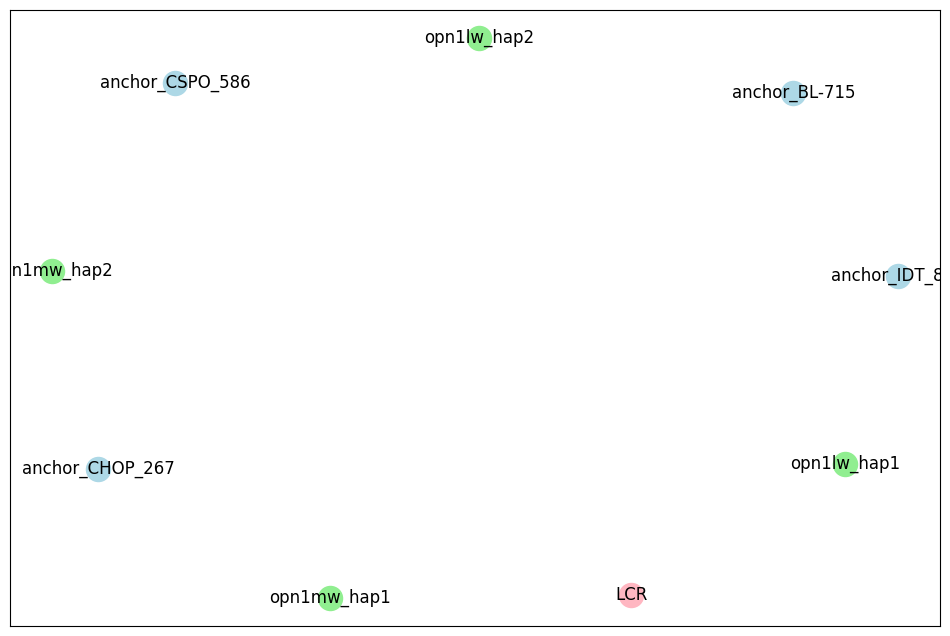

In [73]:
 # Create sequence graph
seq_graph = create_sequence_graph(results_ref, paraphase_nodes, seq_manager)
seq_graph.plot()


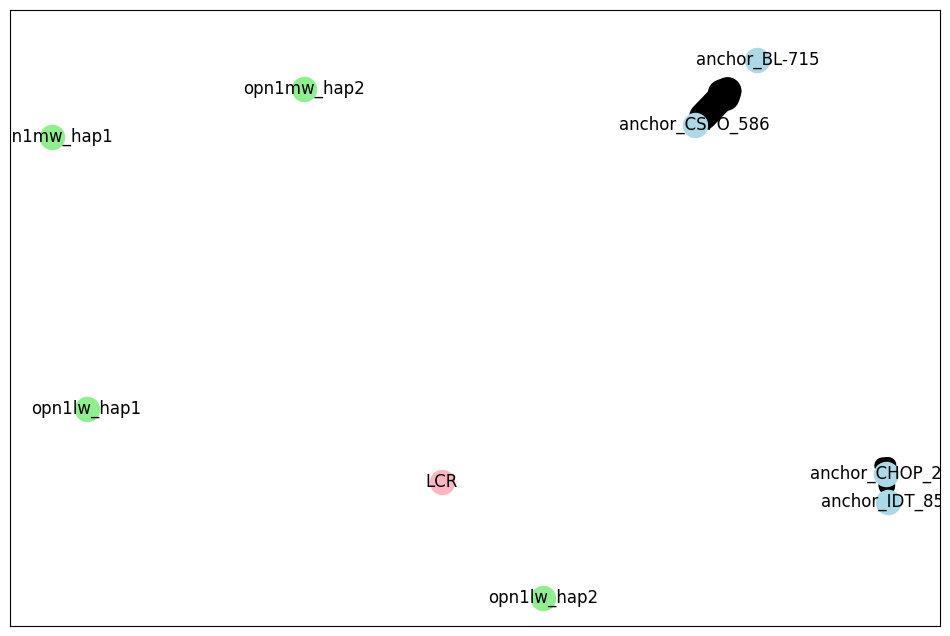

In [ ]:
# Find edges from paraphase nodes
seq_graph.find_connections(results_ref['reads_aligned'], results_ref['anchors_on_reads'], paraphase_nodes)
seq_graph.plot()

In [71]:
# List all edges in the graph with their properties
for edge in seq_graph.graph.edges(data=True):
    start_node = edge[0]
    end_node = edge[1]
    weight = edge[2]['weight']
    num_reads = len(edge[2]['reads'])
    print(f"Edge {start_node} -> {end_node}: {weight} weight, {num_reads} supporting reads")

Edge anchor_CHOP_267 -> anchor_IDT_855: 12 weight, 12 supporting reads
Edge anchor_CSPO_586 -> anchor_BL-715: 20 weight, 20 supporting reads


In [67]:
paraphase_nodes

{'opn1lw': [SequenceNode(id='opn1mw_hap1', sequence='0222222222222222222222222222222221111222221222222222222221211121212112211221111222', source='paraphase', metadata={'supporting_reads': ['30c1b12a-4e60-4156-9205-eaef10015b9e', '0aa8e4e2-ddcf-443d-b0ca-6e65fec65b99', '6cc1d578-890c-425d-8be9-354f06ba4c8b', '9ff90eca-406c-4411-99c1-a2603c2bec36', '4f9aa47f-412e-4597-9fa3-eee032d8fab3', '4e543de6-ddaf-4ab5-b62b-5fb2088069d5', '39d1351a-c1c7-4bd8-ae44-60096667b852', 'e03fa9ee-7187-4cb6-8027-588f7234193c', 'e4e49000-fe79-4059-9b2d-05bc215784fa_sup_154144047_9563'], 'annotated_type': 'opn1mw_LIAVA'}, ref_sequence='CAATTAGGTGGCCTGTTAAATTTTTTTTCTTGAGACAGAGTTTTGCTCTTGTTGCCCAGGCTGGAGTGCAATGGCTCGATCTTGGCTCACCGCAACCTCGACCTCCCAGGTACAAGCGATTCTCCTGTCTCAGCCTCCCAAGTAGCTGGGAGTACAGGTATTTGCCACTAAGCCCAGCTAATTGTTTTTTATTTAGTAGAAACGGGGTTTCACCATGTTAGTCAGGCTGGTCGGGAACTCCTGACCTCAGGAGATCTACCCGCCTTGGCCTCCCAAAGTGCTGGGATTACAGGCGTGTGCCACTGTGCCCAGCCACTTTTTTTTAGACAGAGTCTTGGTCTGTTGCCCAGGCTAGAGTTCAGTGGCGCCATCTCAGCTCACT

In [33]:
seq_graph.discover_novel_sequences(results_ref['reads_aligned'])
seq_graph.plot()
    
    # Map nodes to reference sequence
    seq_graph.find_node_homology(results_ref['seq_ref'])
    
    # Get reference-based node ordering
    ref_structure = seq_graph.get_reference_structure()
    
    # Find optimal path through graph
    best_path, path_weight = seq_graph.find_optimal_path()
    
    # Generate consensus sequence
    if best_path:
        consensus_seq = ''
        for node_id in best_path:
            node = seq_graph.nodes[node_id]
            consensus_seq += node.sequence
            
        results_ref['seq_denovo'] = consensus_seq
    
    # Add graph and reference structure to results
    results_ref['sequence_graph'] = seq_graph
    results_ref['reference_structure'] = ref_structure
    
    return results_ref

IndentationError: unexpected indent (4217340482.py, line 5)